## hw08

### 1. 模拟带drift term的path


In [53]:
import numpy as np
def drifttermBM():
    interval=1/252
    normal=np.random.normal(1,4,252)
    b0=np.sqrt(interval)*normal[0]
    mylist=[b0]
    for i in range(1,252):
        b0+=np.sqrt(interval)*normal[i]
        mylist.append(b0)
    return mylist
        

standardBM()

[0.03553702732809479,
 0.009598553236272199,
 -0.017924396000205074,
 -0.0846766158387825,
 -0.046081291668432896,
 -0.02986482668116039,
 -0.07929960830277055,
 -0.11387243072925629,
 -0.04925538985444476,
 -0.08281237923945972,
 -0.09433320959396398,
 -0.10109457958825482,
 -0.09112811922201504,
 -0.039909570533438854,
 0.07308993839213172,
 0.10143189558338302,
 0.06663846249394278,
 0.1100601659278949,
 0.01071116293221143,
 0.007068721077690518,
 0.04647849949792798,
 0.11313768142759355,
 0.07168621651905213,
 0.08042273433978193,
 0.11855269782834402,
 0.048786736137892264,
 0.039607586644777,
 -0.01808885349993091,
 -0.031028308480665404,
 -0.006040134332758955,
 0.03147675608253347,
 0.0674432959997484,
 0.08026173871051111,
 -0.06811260864467296,
 0.010357520700021397,
 -0.02747547542876167,
 0.002157573768785715,
 0.025299016731601304,
 0.009225129017334455,
 -0.017579643198949026,
 -0.017036338970588923,
 0.03181792858142578,
 0.19654504477412665,
 0.25596213168096577,
 0.2

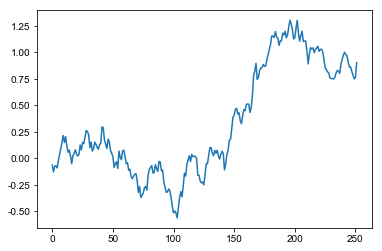

In [54]:
plt.plot(standardBM())

### 2. 了解其他期权组合及其收益图


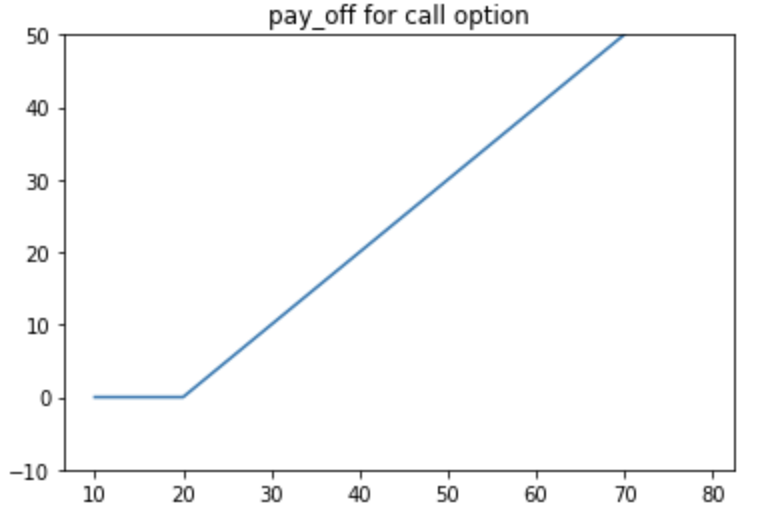

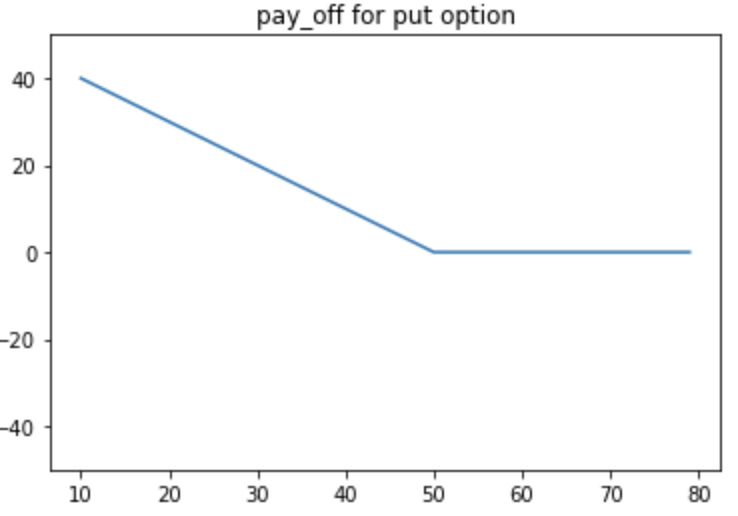